# EXPERIMENTACIÓN:

In [13]:
# ============================================================
#  PLN - Proyecto Tweets Aseguradoras (Módulo 1: Léxico)
#  Versión ajustada para mejorar detección de marcas
# ============================================================

# --------- 0) Setup de entorno (instala si falta) ----------
import sys, subprocess, importlib

def ensure(pkg, pip_name=None):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name or pkg])

# Librerías base
ensure("pandas")
ensure("numpy", "numpy<2.0")
ensure("regex")
ensure("unidecode")
ensure("nltk")
ensure("sklearn", "scikit-learn")

import pandas as pd
import numpy as np
import regex as re
from unidecode import unidecode
import nltk
nltk.download('punkt', quiet=True)
from nltk.stem.snowball import SpanishStemmer

# spaCy (modelo español)
ensure("spacy")
import spacy
try:
    nlp = spacy.load("es_core_news_sm")
except:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_sm"])
    nlp = spacy.load("es_core_news_sm")

# --------- 1) Parámetros de proyecto -----------------------
EXCEL_PATH = r"C:\Users\santi\Downloads\Learning\Maestria\Programacion Lenguaje Natural\Proyecto\Inputs\2053806800_Aseguradoras+Query.xlsx"
SHEET_NAME = "Hoja1"

# Columnas esperadas (ajusta si varían)
COL_DATE   = "Date"
COL_TITLE  = "Title"
COL_SNIPP  = "Snippet"
COL_URL    = "Url"
COL_DOMAIN = "Domain"
COL_LANG   = "Language"
COL_COUNTRY = "Country"
TEXT_COL   = "text_raw"

# MWE (frases fijas)
MWE_SERVICE = [
    "atención al cliente", "pago de siniestro", "tiempo de respuesta",
    "radicado de pqrs", "red médica", "autorización de servicio",
    "incremento de prima", "línea de atención"
]

MWE_ENTITIES = [
    "grupo sura", "fondo de pensiones obligatorias"
]

# Gazetteer de marcas
BRANDS = {
    "seguros bolivar": {"seguros bolívar", "seguros bolivar", "@segurosbolivar",
                        "grupobolivar", "grupo bolívar", "grupo bolivar", "segurosbolivar"},
    "sura": {"sura", "grupo sura", "@suramericana", "suramericana"},
    "axa colpatria": {"axa colpatria", "@axacolpatria", "colpatria seguros","axacolpatria"},
    "mapfre": {"mapfre", "@mapfre_col","mapfre_co"},
    "allianz": {"allianz", "@allianzcol"},
    "liberty seguros": {"liberty seguros", "@libertycol"},
    "zurich": {"zurich", "@zurichcolombia"},
    "hdi seguros": {"hdi seguros", "@hdi_segurosco"},
    "seguros del estado": {"seguros del estado", "@segurosdelestado"},
    "porvenir": {"porvenir", "@porvenir", "fondo de pensiones obligatorias porvenir"},
    "Fiduciaria La Previsora": {"fiduciaria la previsora", "@fiduciarialaprevisora",
                                "fiduciaria la previsora","previsora","la previsora s.a. compañía de seguros"},
    "Positiva Compañía de Seguros": {"positiva compañía de seguros", "positivacol"},
}

# Mapping dominio -> marca
DOMAIN2BRAND = {
    "segurosbolivar.com": "seguros bolivar",
    "grupobolivar.com": "seguros bolivar",
    "sura.com": "sura",
    "segurossura.com": "sura",
    "axacolpatria.co": "axa colpatria",
    "mapfre.com": "mapfre",
    "allianz.co": "allianz",
    "libertycolombia.com": "liberty seguros",
    "zurich.com.co": "zurich",
    "hdi.com.co": "hdi seguros",
    "segurosdelestado.com": "seguros del estado",
    "porvenir.com.co": "porvenir",
}

# Stopwords de dominio
DOMAIN_STOPWORDS = {
    "seguros", "aseguradora", "aseguradoras", "póliza", "poliza", "asegurado", "asegurada",
    *set(DOMAIN2BRAND.values()), *set(BRANDS.keys()),
}

# --------- 2) Normalización ------------------
URL_RE = re.compile(r"https?://\S+|www\.\S+", flags=re.IGNORECASE)
MENTION_RE = re.compile(r"@\w+", flags=re.IGNORECASE)
HASHTAG_RE = re.compile(r"#\w+", flags=re.IGNORECASE)
MULTISPACE_RE = re.compile(r"\s+")

def basic_clean(text: str) -> str:
    """Limpieza robusta: conserva menciones y hashtags como texto legible."""
    if not isinstance(text, str):
        return ""
    t = text

    # ⚙️ Guardar dominios antes de eliminar URLs
    urls = re.findall(URL_RE, t)
    t = URL_RE.sub(" ", t)

    # ⚙️ Mantener menciones sin @ (para que 'segurosbolivar' siga apareciendo)
    t = MENTION_RE.sub(lambda m: " " + m.group(0)[1:] + " ", t)

    # ⚙️ Conservar hashtags como palabras (sin #)
    t = HASHTAG_RE.sub(lambda m: " " + m.group(0)[1:] + " ", t)

    # Limpieza general
    t = t.replace("’", "'").replace("“", '"').replace("”", '"')
    t = t.lower()
    t = MULTISPACE_RE.sub(" ", t).strip()

    # ⚙️ Añadir URLs al final para detección de dominio
    if urls:
        t += " " + " ".join(urls)
    return t


def ascii_fold(text: str) -> str:
    """Quita tildes y normaliza a minúsculas."""
    return unidecode(text or "").lower()

def block_mwes(text: str, mwe_list) -> str:
    """Reemplaza espacios en MWE por '_' para tratarlas como tokens únicos."""
    t = " " + text + " "
    for phrase in sorted(mwe_list, key=len, reverse=True):
        p_norm = ascii_fold(phrase)
        pattern = re.escape(p_norm).replace(r"\ ", r"\s+")
        rx = re.compile(rf"(?i)(?<!\w){pattern}(?!\w)")
        t_norm = ascii_fold(t)
        t_norm = rx.sub(phrase.replace(" ", "_"), t_norm)
        t = t_norm
    return t.strip()

# --------- 3) Extracción de marcas -------------------------
def extract_brands(text_norm: str, domain: str = "") -> list:
    """Detección flexible de marcas: menciones pegadas, hashtags y dominios."""
    found = set()
    t = ascii_fold(text_norm)

    # Búsqueda por texto
    for brand, aliases in BRANDS.items():
        for alias in aliases | {brand}:
            alias_norm = ascii_fold(alias)
            # ⚙️ patrón flexible: detecta alias pegados (#, @, sin espacios)
            pattern = rf"(?<!\w){re.escape(alias_norm)}(?!\w)"
            if re.search(pattern, t):
                found.add(brand)
                break

    # Búsqueda por dominio (URL o columna)
    d = (domain or "").lower().strip()
    d = d.replace("https://", "").replace("http://", "")
    d = d.split("/")[0] if d else d
    for suf, bname in DOMAIN2BRAND.items():
        if suf in t or d.endswith(suf):
            found.add(bname)

    return sorted(found)

def pick_primary_brand(brands: list, text_norm: str) -> str:
    """Escoge la marca principal por posición de aparición."""
    if not brands:
        return ""
    t = ascii_fold(text_norm)
    positions = []
    for b in brands:
        aliases = list(BRANDS.get(b, [])) + [b]
        pos_min = min([t.find(ascii_fold(a)) for a in aliases if ascii_fold(a) in t] or [10**9])
        positions.append((pos_min, b))
    positions.sort(key=lambda x: x[0])
    return positions[0][1] if positions[0][0] < 10**9 else sorted(brands)[0]

# --------- 4) Tokenización -------------------
stemmer = SpanishStemmer()

def tokenize_lemma(text_blocked: str) -> list:
    doc = nlp(text_blocked)
    toks = [tok.lemma_ for tok in doc if not tok.is_space and not tok.is_punct]
    return [t for t in toks if t]

def tokenize_stem(text_blocked: str) -> list:
    doc = nlp(text_blocked)
    toks = [stemmer.stem(tok.text.strip()) for tok in doc if not tok.is_space and not tok.is_punct]
    return [t for t in toks if t]

# --------- 5) Métricas EDA -------------------
def ttr(tokens: list) -> float:
    return (len(set(tokens)) / max(1, len(tokens))) if tokens else 0.0

def hapax_ratio(tokens: list) -> float:
    if not tokens:
        return 0.0
    from collections import Counter
    c = Counter(tokens)
    hapax = sum(1 for _, f in c.items() if f == 1)
    return hapax / len(c)

# ============================================================
#  A) CARGA DE DATOS
# ============================================================
df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
if "id" not in df.columns.str.lower():
    df.insert(0, "id", range(1, len(df)+1))

df[TEXT_COL] = (df.get(COL_TITLE, "").fillna("").astype(str) + " " +
                df.get(COL_SNIPP, "").fillna("").astype(str)).str.strip()

if COL_LANG in df.columns:
    df = df[df[COL_LANG].str.lower().isin(["es", "español"])]

df = df.reset_index(drop=True)
print(f"Registros cargados: {len(df)}")

# ============================================================
#  B) LIMPIEZA + MWE
# ============================================================
df["text_clean_base"] = df[TEXT_COL].map(basic_clean)
df["text_mwe_entities"] = df["text_clean_base"].map(lambda t: block_mwes(t, MWE_ENTITIES))
df["text_blocked"] = df["text_mwe_entities"].map(lambda t: block_mwes(t, MWE_SERVICE))

# ============================================================
#  C) EXTRACCIÓN DE MARCAS
# ============================================================
df["brand_list"] = df.apply(lambda r: extract_brands(r["text_blocked"], r.get(COL_DOMAIN, "")), axis=1)
df["brand_primary"] = df.apply(lambda r: pick_primary_brand(r["brand_list"], r["text_blocked"]), axis=1)

# ============================================================
#  D) TOKENIZACIÓN + TEXTOS
# ============================================================
df["tokens_lemma"] = df["text_blocked"].map(tokenize_lemma)
df["tokens_stem"]  = df["text_blocked"].map(tokenize_stem)

def remove_domain_words(tokens: list) -> list:
    return [t for t in tokens if t not in DOMAIN_STOPWORDS]

df["tokens_topics"] = df["tokens_lemma"].map(remove_domain_words)
df["text_lemma"]  = df["tokens_lemma"].map(lambda xs: " ".join(xs))
df["text_stem"]   = df["tokens_stem"].map(lambda xs: " ".join(xs))
df["text_topics"] = df["tokens_topics"].map(lambda xs: " ".join(xs))

# ============================================================
#  E) MÉTRICAS EDA
# ============================================================
df["n_chars_raw"]    = df[TEXT_COL].str.len().fillna(0).astype(int)
df["n_tokens_lemma"] = df["tokens_lemma"].map(len)
df["n_tokens_topics"]= df["tokens_topics"].map(len)
df["ttr_lemma"]      = df["tokens_lemma"].map(ttr)
df["hapax_lemma"]    = df["tokens_lemma"].map(hapax_ratio)

eda_by_brand = (
    df.groupby("brand_primary", dropna=False)
      .agg(n_docs=("id","count"),
           mean_len=("n_tokens_lemma","mean"),
           mean_ttr=("ttr_lemma","mean"))
      .sort_values("n_docs", ascending=False)
)
print(eda_by_brand.head(10))

# ============================================================
#  F) EXPORT "CONJUNTO MEDIDO"
# ============================================================
cols_measured = [
    "id", COL_DATE, COL_DOMAIN, COL_URL,
    TEXT_COL, "text_clean_base", "text_blocked",
    "brand_list", "brand_primary",
    "text_lemma", "text_stem", "text_topics",
    "n_chars_raw", "n_tokens_lemma", "n_tokens_topics",
    "ttr_lemma", "hapax_lemma",
]
export_df = df[[c for c in cols_measured if c in df.columns]].copy()

OUTPUT_CSV = "corpus_medido2.csv"
OUTPUT_PQ  = "corpus_medido2.parquet"

export_df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
try:
    export_df.to_parquet(OUTPUT_PQ, index=False)
except Exception as e:
    print("Parquet no disponible -> solo CSV. Error:", e)

print(f"Exportado: {OUTPUT_CSV} (y parquet si estuvo disponible)")

Registros cargados: 15469
                              n_docs   mean_len  mean_ttr
brand_primary                                            
                                4987  53.885101  0.627808
seguros bolivar                 3379  56.077242  0.557132
Fiduciaria La Previsora         1915  59.916971  0.582862
sura                            1702  56.796122  0.631199
mapfre                          1187  55.144061  0.636045
Positiva Compañía de Seguros     933  58.722401  0.452000
axa colpatria                    663  56.457014  0.578748
allianz                          316  53.050633  0.686732
liberty seguros                  186  54.258065  0.690902
hdi seguros                      109  59.155963  0.659051
Exportado: corpus_medido2.csv (y parquet si estuvo disponible)


In [14]:
# ============================
# TOP N-GRAMAS (bigramas/trigramas)
# ============================
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# --- Stopwords español (generales) ---
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
sw_es = set(stopwords.words('spanish'))

# Si quieres quitar también tus stopwords de dominio en TEMAS:
from collections import Counter
# DOMAIN_STOPWORDS viene del bloque anterior (marcas, 'seguros', etc.)
sw_temas = sw_es.union(DOMAIN_STOPWORDS)

def top_ngrams(texts, ngram_range=(2,2), top_k=50, stopwords_set=None, min_df=2):
    """
    Devuelve un DataFrame con los top n-gramas por frecuencia absoluta.
    - texts: iterable de strings
    - ngram_range: (2,2) bigramas, (3,3) trigramas, etc.
    - stopwords_set: set de stopwords a remover
    - min_df: descarta n-gramas que aparecen en < min_df documentos
    """
    if stopwords_set is None:
        stopwords_set = set()

    # CountVectorizer respeta '_' si usamos token_pattern amplio
    vect = CountVectorizer(
        ngram_range=ngram_range,
        lowercase=False,
        token_pattern=r'(?u)\b\w+\b',
        min_df=min_df,
        stop_words=list(stopwords_set) if stopwords_set else None
    )
    X = vect.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vect.get_feature_names_out())
    order = np.argsort(freqs)[::-1][:top_k]
    out = pd.DataFrame({
        "ngram": terms[order],
        "freq": freqs[order],
        "df": np.asarray((X > 0).sum(axis=0)).ravel()[order]
    })
    return out

# --- 1A) N-gramas de TEMAS (contenido) ---
# Usamos text_topics (lemas + MWE de servicio, sin marcas) y quitamos stopwords generales+dominio
texts_topics = df["text_topics"].fillna("").astype(str).tolist()
top_bi_topics  = top_ngrams(texts_topics, (2,2), top_k=50, stopwords_set=sw_temas, min_df=2)
top_tri_topics = top_ngrams(texts_topics, (3,3), top_k=50, stopwords_set=sw_temas, min_df=2)

print("\nTop 20 BIGRAMAS (TEMAS):")
print(top_bi_topics.head(20).to_string(index=False))

print("\nTop 20 TRIGRAMAS (TEMAS):")
print(top_tri_topics.head(20).to_string(index=False))


c:\Users\santi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['Compañía', 'Fiduciaria', 'La', 'Positiva', 'Previsora', 'Seguros', 'axa', 'bolivar', 'colpatria', 'hdi', 'liberty'] not in stop_words.
  warnings.warn(



Top 20 BIGRAMAS (TEMAS):
                ngram  freq   df
              https t  7579 3275
                 t co  7579 3275
       seguro bolivar  2339 1747
           grupo argo  2328 1477
      junta directivo   752  523
      argo grupo_sura   701  529
         cemento argo   642  437
        axa colpatria   628  463
     grupo_sura grupo   536  415
      mensaje directo   504  251
    ricardo jaramillo   498  332
      mensaje privado   478  239
      compania seguro   469  361
 fiduciaria previsora   450  405
presidente grupo_sura   430  313
    acción grupo_sura   390  301
          previsora s   368  324
      seguro colombia   356  279
         grupo nutrés   354  296
       liberty seguro   333  264

Top 20 TRIGRAMAS (TEMAS):
                                    ngram  freq   df
                               https t co  7579 3275
                    grupo argo grupo_sura   607  463
                    grupo_sura grupo argo   423  315
   davidracero positivacol colombiacompra 

In [16]:
# ============================
# PALABRAS POCO FRECUENTES + FORMAS DE MENCIÓN
# ============================
import re
from collections import Counter
import numpy as np
import pandas as pd

# --- 2A) Rare terms (sin stopwords generales) ---
# Usamos tokens "lemma" para tener formas comparables, PERO no removemos marcas
# (porque queremos ver variantes). Sí quitamos stopwords generales.
def rare_terms_from_tokens(list_of_token_lists, stopwords_set, min_len=3, max_freq=3):
    """
    Retorna un DataFrame con términos cuya frecuencia total <= max_freq,
    excluyendo stopwords y tokens muy cortos/no alfanuméricos.
    """
    counter = Counter()
    for toks in list_of_token_lists:
        for t in toks:
            if t and len(t) >= min_len and re.search(r"[a-z0-9áéíóúñ_]", t):
                if t not in stopwords_set:
                    counter[t] += 1
    items = [(t, f) for t, f in counter.items() if f <= max_freq]
    out = pd.DataFrame(items, columns=["term", "freq"]).sort_values(["freq","term"])
    return out

rare_terms = rare_terms_from_tokens(
    df["tokens_lemma"].apply(lambda x: x if isinstance(x, list) else []).tolist(),
    stopwords_set=sw_es,
    min_len=3,
    max_freq=3,
)


print("\nRARE TERMS (<=3): muestra de 30")
print(rare_terms.head(30).to_string(index=False))
print(f"Total rare terms (<=3): {len(rare_terms)}")

# Puedes filtrar candidates que "suenen a marca" (porvenir, sura, bolivar, mapfre, allianz...)
looks_like_brand = rare_terms[rare_terms["term"].str.contains(
    r"(sura|bolivar|bolívar|mapfre|allianz|colpatria|zurich|liberty|hdi|porvenir)",
    case=False, regex=True
)]
print("\nRARE TERMS que parecen marcas/variantes (muestra 30):")
print(looks_like_brand.head(30).to_string(index=False))


# --- 2B) N-gramas que incluyen una marca (formas de mención) ---
# Tomamos text_blocked (con MWE unidas por '_') para capturar cosas como 'grupo_sura'
texts_blocked = df["text_blocked"].fillna("").astype(str).tolist()

# Construimos un set plano de alias (ya está en minúsculas en tu pipeline)
brand_alias_flat = set()
for brand, aliases in BRANDS.items():
    brand_alias_flat.add(brand)
    for a in aliases:
        brand_alias_flat.add(a.lower())

# Un pequeño vectorizador SIN stopwords para no perder marcas
def ngram_counts_including_brands(texts, ngram_range=(2,2), min_df=1):
    vect = CountVectorizer(
        ngram_range=ngram_range, lowercase=False,
        token_pattern=r'(?u)\b\w+\b', min_df=min_df
    )
    X = vect.fit_transform(texts)
    terms = np.array(vect.get_feature_names_out())
    freqs = np.asarray(X.sum(axis=0)).ravel()
    dfs   = np.asarray((X > 0).sum(axis=0)).ravel()
    df_terms = pd.DataFrame({"ngram": terms, "freq": freqs, "df": dfs})
    # filtra los n-gramas que contienen algún alias/marca
    mask = df_terms["ngram"].apply(
        lambda s: any(b in s for b in brand_alias_flat)
    )
    return df_terms[mask].sort_values("freq", ascending=False)

brand_bigrams  = ngram_counts_including_brands(texts_blocked, (2,2), min_df=1)
brand_trigrams = ngram_counts_including_brands(texts_blocked, (3,3), min_df=1)

print("\nFORMAS DE MENCIÓN (BIGRAMAS con marca) - Top 30:")
print(brand_bigrams.head(30).to_string(index=False))

print("\nFORMAS DE MENCIÓN (TRIGRAMAS con marca) - Top 30:")
print(brand_trigrams.head(30).to_string(index=False))



RARE TERMS (<=3): muestra de 30
                   term  freq
             "bienestar     1
                    "el     1
         "investigacion     1
                   )por     1
                 +0,16%     1
                  +0,2%     1
                 +0,51%     1
                  +0,6%     1
                 +0,64%     1
                  +0,7%     1
                 +0,84%     1
                  +0,86     1
                  +0,89     1
                 +0,98%     1
       +0.17%118,245.45     1
        +0.32%12,540.00     1
     +0.33%21,178.58btc     1
                 +0.60%     1
   +0.70%17,380.00dolar     1
+0.86%47,060.00grupoarg     1
                 +1,04%     1
                 +1,26%     1
                 +1,42%     1
                 +1,59%     1
                  +1,69     1
                 +1,71%     1
                 +1,96%     1
                 +1.03%     1
        +1.22%18,137.85     1
      +1.26%4,159.67bvc     1
Total rare terms (<=3): 19774

RARE T

C:\Users\santi\AppData\Local\Temp\ipykernel_13576\3704906943.py:40: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  looks_like_brand = rare_terms[rare_terms["term"].str.contains(



FORMAS DE MENCIÓN (BIGRAMAS con marca) - Top 30:
                     ngram  freq   df
              la previsora  2582 1776
           seguros bolivar  2342 1750
             de grupo_sura  1900 1371
              seguros sura  1115  729
            del grupo_sura   861  622
              grupo_sura y   835  655
             axa colpatria   657  483
             el grupo_sura   648  491
              y grupo_sura   618  460
         previsora seguros   541  296
       segurosbolivar hola   430  215
               previsora s   406  353
             en grupo_sura   347  266
           liberty seguros   333  264
             grupo bolivar   314  263
                    sura y   303  241
positivacol colombiacompra   300  150
   davidracero positivacol   298  149
                   de sura   293  236
          allianz colombia   274  223
 davivienda segurosbolivar   248  127
                  eps sura   247  159
            con grupo_sura   246  185
             grupo_sura en   245  184


Primeros Ajustes:


In [20]:
# --- 1A) Ampliar MWE (servicio) y entidades/noticioso/CM ---
MWE_SERVICE += [
    "pago de siniestro","pago de la póliza","tiempo de respuesta","atención al cliente",
    "servicio al cliente","línea de atención","red médica","autorización de servicio",
    "incremento de prima","renovación de póliza","radicado de pqrs","letra pequeña"
]
MWE_ENTITIES += [
    "grupo argos","grupo sura","grupo empresarial antioqueño","suramericana s a",
    "inversiones suramericana","fundacion mapfre","allianz colombia","seguros del estado"
]

# --- 1B) Alias/typos para marcas (gazetteer) ---
BRANDS["seguros bolivar"] |= {
    "seguros bolívar","segurosbolivar","#segurosbolivar","#segurosbolívar",
    "grupo bolívar","grupo bolivar","grupobolivar","agrobolivar","bolivar seguros"
}
BRANDS["sura"] |= {
    "grupo sura","gruposura","grup_sura","grupsura","suramericana","eps sura",
    "inversiones suramericana","suramericana s a","@suramericana","segurossura"
}
BRANDS["mapfre"] |= {"fundacion mapfre","mapfre col","mapfre_col","2024mapfre"}
BRANDS["allianz"] |= {"allianz colombia","allianz.co","allianzcol","allianzcolombio"}
BRANDS["axa colpatria"] |= {"axacolpatria","colpatria seguros","axacolpatriar"}
BRANDS["liberty seguros"] |= {"liberty seguros","legal-liberty"}
BRANDS["seguros del estado"] |= {"seguros del estado"}
BRANDS["zurich"] |= {"zurich colombia"}
BRANDS["hdi seguros"] |= {"hdi seguros"}
BRANDS["porvenir"] |= {"porvenir","fondo de pensiones obligatorias porvenir"}

# --- 1C) Dominios por sufijo ---
DOMAIN_SUFFIX2BRAND = {
    "segurosbolivar.com":"seguros bolivar","grupobolivar.com":"seguros bolivar",
    "segurossura.com":"sura","sura.com":"sura","epssura.com":"sura",
    "axacolpatria.co":"axa colpatria","allianz.co":"allianz","mapfre.com":"mapfre",
    "fundacionmapfre.org":"mapfre","libertycolombia.com":"liberty seguros",
    "zurich.com.co":"zurich","hdi.com.co":"hdi seguros","segurosdelestado.com":"seguros del estado",
    "porvenir.com.co":"porvenir"
}

# --- 1D) Stopwords de dominio (solo para TEMAS) ---
DOMAIN_STOPWORDS |= {
    "seguro","seguros","aseguradora","aseguradoras","poliza","póliza","cliente","clientes",
    "grupo","fundacion","fundación","colombia","colombiano","colombianos",
    *set(BRANDS.keys())
}

# --- 1E) Normalizaciones canónicas antes de tokenizar ---
CANON_REPL = [
    (r"\bjunta directivo\b","junta directiva"),
    (r"\bcemento argo\b","cementos argos"),
    (r"\bprevisora s\b","previsora s.a."),
    (r"\bseguro bolivar\b","seguros bolivar"),
    (r"\bseguro surar\b","seguros sura"),
    (r"\bcompan[ií]a seguro\b","compañía de seguros"),
    (r"\bgrupo nutr[ée]s?\b","grupo nutresa"),
]
def canonicalize(text: str) -> str:
    t = text
    for pat, rep in CANON_REPL:
        t = re.sub(pat, rep, t, flags=re.IGNORECASE)
    return t

# --- 1F) Flags para filtrar corporativo y respuestas de CM ---
CORP_NEWS_PATTERNS = {
    "grupo_sura","grupo argos","argos grupo","junta directiv","presidente",
    "grupo empresarial antioque","acciones","accionistas",
    "inversiones suramericana","suramericana s a","edificio seguros bolivar"
}
CM_TEMPLATES = {
    "mensaje directo","mensaje privado","favor escrib","invitamos contactar",
    "pagina oficial","facebook","instagram","contactarno pagina","medio mensaje directo"
}
def is_corporate_news(t: str) -> bool:
    return any(pat in ascii_fold(t) for pat in CORP_NEWS_PATTERNS)
def is_cm_template(t: str) -> bool:
    return any(pat in ascii_fold(t) for pat in CM_TEMPLATES)

# --- 1G) extract_brands actualizado (texto + dominio por sufijo) ---
def extract_brands(text_norm: str, domain: str = "") -> list:
    found = set()
    t = " " + ascii_fold(text_norm) + " "
    for brand, aliases in BRANDS.items():
        if any((" " + ascii_fold(a) + " ") in t for a in (aliases | {brand})):
            found.add(brand)
    d = (domain or "").lower().strip()
    d = d.replace("https://","").replace("http://","").split("/")[0]
    d = d[4:] if d.startswith("www.") else d
    for suffix, brand in DOMAIN_SUFFIX2BRAND.items():
        if d.endswith(suffix):
            found.add(brand)
    return sorted(found)


In [21]:
# Re-aplica limpieza canónica
df["text_clean_base"] = df["text_clean_base"].map(canonicalize)

# Re-bloquea MWE (entidades primero, luego servicio)
df["text_mwe_entities"] = df["text_clean_base"].map(lambda t: block_mwes(t, MWE_ENTITIES))
df["text_blocked"] = df["text_mwe_entities"].map(lambda t: block_mwes(t, MWE_SERVICE))

# Recalcula marcas
df["brand_list"] = df.apply(lambda r: extract_brands(r["text_blocked"], r.get(COL_DOMAIN, "")), axis=1)
df["brand_primary"] = df.apply(lambda r: pick_primary_brand(r["brand_list"], r["text_blocked"]), axis=1)

# Flags corporativo/CM
df["flag_corp_news"] = df["text_clean_base"].map(is_corporate_news)
df["flag_cm_reply"]  = df["text_clean_base"].map(is_cm_template)

# Tokens y textos para TEMAS (lema + sin marcas)
df["tokens_lemma"] = df["text_blocked"].map(tokenize_lemma)
df["tokens_topics"] = df["tokens_lemma"].map(lambda xs: [t for t in xs if t not in DOMAIN_STOPWORDS])
df["text_topics"]   = df["tokens_topics"].map(lambda xs: " ".join(xs))

# Subconjunto tema-centrado (sug.) para sacar n-gramas “limpios”
df_topics = df[~df["flag_corp_news"] & ~df["flag_cm_reply"]].copy()
len(df), len(df_topics)


(15469, 10684)

In [22]:
# --- TOP N-GRAMAS (TEMAS) sobre df_topics ---
texts_topics = df_topics["text_topics"].fillna("").astype(str).tolist()

top_bi_topics  = top_ngrams(texts_topics, (2,2), top_k=50, stopwords_set=sw_temas, min_df=2)
top_tri_topics = top_ngrams(texts_topics, (3,3), top_k=50, stopwords_set=sw_temas, min_df=2)

print("\nTop 20 BIGRAMAS (TEMAS, filtrado corporativo/CM):")
print(top_bi_topics.head(20).to_string(index=False))
print("\nTop 20 TRIGRAMAS (TEMAS, filtrado corporativo/CM):")
print(top_tri_topics.head(20).to_string(index=False))

# --- RARE TERMS (para detectar alias) en df (global) ---
brand_regex = r"(sura|bol[ií]var|mapfre|allianz|colpatria|zurich|liberty|hdi|porvenir|suramericana|argos)"
token_lists = df["tokens_lemma"].apply(
    lambda x: x if isinstance(x, list)
    else ([] if pd.isna(x) else (x.split() if isinstance(x, str) else []))
)
rare_terms = rare_terms_from_tokens(
    token_lists.tolist(),
    stopwords_set=sw_es,
    min_len=3,
    max_freq=3
)
looks_like_brand = rare_terms[rare_terms["term"].str.contains(brand_regex, case=False, regex=True, na=False)]
print("\nRARE TERMS que parecen marcas/variantes (muestra 30):")
print(looks_like_brand.head(30).to_string(index=False))

# --- FORMAS DE MENCIÓN (n-gramas con marca) sobre df (global) ---
texts_blocked = df["text_blocked"].fillna("").astype(str).tolist()
brand_bigrams  = ngram_counts_including_brands(texts_blocked, (2,2), min_df=1)
brand_trigrams = ngram_counts_including_brands(texts_blocked, (3,3), min_df=1)

print("\nFORMAS DE MENCIÓN (BIGRAMAS con marca) - Top 30:")
print(brand_bigrams.head(30).to_string(index=False))
print("\nFORMAS DE MENCIÓN (TRIGRAMAS con marca) - Top 30:")
print(brand_trigrams.head(30).to_string(index=False))


c:\Users\santi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['Compañía', 'Fiduciaria', 'La', 'Positiva', 'Previsora', 'Seguros', 'axa', 'bolivar', 'colpatria', 'hdi', 'liberty'] not in stop_words.
  warnings.warn(



Top 20 BIGRAMAS (TEMAS, filtrado corporativo/CM):
                        ngram  freq   df
                         t co  5835 2462
                      https t  5835 2462
   positivacol colombiacompra   300  150
      davidracero positivacol   293  146
colombiacompra wradiocolombia   290  145
                sistema salud   222  151
        dcoronell davidracero   210  105
                    nuevo eps   199  106
                       si ser   191  116
                      ser mas   189  125
            primero trimestre   186  119
               integral salud   180   87
       aseguramiento integral   180   87
             primero semestre   175  118
                utilidad neta   171  111
           patinaje velocidad   167   84
   daviviendir segurosbolivar   165   92
           davivienda bolivar   164  140
                    haber ser   159  116
               riesgo laboral   144   76

Top 20 TRIGRAMAS (TEMAS, filtrado corporativo/CM):
                                    

C:\Users\santi\AppData\Local\Temp\ipykernel_13576\1020284944.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  looks_like_brand = rare_terms[rare_terms["term"].str.contains(brand_regex, case=False, regex=True, na=False)]



RARE TERMS que parecen marcas/variantes (muestra 30):
                                                                         term  freq
                                                               -axa_colpatria     1
                                                                   -colpatria     1
                                                                 -grupo_argos     1
                                                             0,00%.grupo_sura     1
                                                             1.07%.grupo_sura     1
                                                             2,45%.grupo_sura     1
                                                                   2024mapfre     1
                                                                  agrobolivar     1
                                                                   allianz.co     1
                                                               allianz.sandra     1
                     

In [23]:
# --- ENTIDADES (bloqueo como unidad, no para TEMAS) ---
MWE_ENTITIES += [
    "fiduciaria previsora", "previsora s.a.", "axa colpatria"
]

# --- BRANDS (alias/typos detectados) ---
BRANDS.setdefault("fiduciaria previsora", set())
BRANDS["fiduciaria previsora"] |= {"fiduciaria previsora", "previsora s", "previsora s.a.", "previsora"}

BRANDS["axa colpatria"] |= {"axacolpatria", "-colpatria"}  # aparece en rare terms

DOMAIN_STOPWORDS |= {
    "fiduciaria", "previsora", "previsora s.a.", "axa", "colpatria", "axa colpatria"
}
# Amplía los patrones de CM
CM_TEMPLATES |= {
    "dejar link", "link dej", "aqui dejar link",
    "atenderte manera", "atenderte manera directo",
    "herramienta atenderte", "solventar caso", "poder solventar caso",
    "medio mensaje directo", "favor escribano mensaje", "mensaje directo atento"
}

MWE_ENTITIES += [
    "dejar link", "atenderte manera directo", "herramienta atenderte manera",
    "solventar caso manera"
]

CORP_NEWS_PATTERNS |= {
    "utilidad neta", "primero trimestre", "primer trimestre",
    "primero semestre", "primer semestre", "value and risk",
    "patinaje velocidad", "davivienda bolivar", "nuevo modelo salud",
    "aseguramiento integral salud", "sistema salud", "integral salud",
    "seguridad salud trabajo", "fondo nacional", "gestion riesgo", "riesgo laboral"
}

STOPWORDS_EXTRA = {
    "ser","haber","poder","mas","si","nuevo","empresa","nacional","gestión","riesgo","integral"
}
DOMAIN_STOPWORDS |= STOPWORDS_EXTRA

CANON_REPL += [
    (r"\bprevisora s\b","previsora s.a."),
    (r"\bvalue and risk\b","value and risk"),  # si decides filtrar, basta con el patrón en CORP_NEWS_PATTERNS
    (r"\bprimero semestre\b","primer semestre"),
    (r"\bprimero trimestre\b","primer trimestre"),
]

NUMPCT_TOKEN_RE = re.compile(r"(?=.*\d)(?=.*[%\.,])")  # contiene dígitos y %/./, mezclados

def remove_num_pct_tokens(tokens):
    return [t for t in tokens if not NUMPCT_TOKEN_RE.search(t)]

# aplica sólo a TEMAS:
df["tokens_topics"] = df["tokens_lemma"].map(lambda xs: remove_num_pct_tokens(
    [t for t in xs if t not in DOMAIN_STOPWORDS]
))
df["text_topics"] = df["tokens_topics"].map(lambda xs: " ".join(xs))

NUMPCT_TOKEN_RE = re.compile(r"(?=.*\d)(?=.*[%\.,])")  # contiene dígitos y %/./, mezclados

def remove_num_pct_tokens(tokens):
    return [t for t in tokens if not NUMPCT_TOKEN_RE.search(t)]

# aplica sólo a TEMAS:
df["tokens_topics"] = df["tokens_lemma"].map(lambda xs: remove_num_pct_tokens(
    [t for t in xs if t not in DOMAIN_STOPWORDS]
))
df["text_topics"] = df["tokens_topics"].map(lambda xs: " ".join(xs))

# Reaplica canonicalize
df["text_clean_base"] = df["text_clean_base"].map(canonicalize)

# Rebloquea MWE
df["text_mwe_entities"] = df["text_clean_base"].map(lambda t: block_mwes(t, MWE_ENTITIES))
df["text_blocked"] = df["text_mwe_entities"].map(lambda t: block_mwes(t, MWE_SERVICE))

# Recalcula marcas + flags
df["brand_list"] = df.apply(lambda r: extract_brands(r["text_blocked"], r.get(COL_DOMAIN, "")), axis=1)
df["brand_primary"] = df.apply(lambda r: pick_primary_brand(r["brand_list"], r["text_blocked"]), axis=1)
df["flag_corp_news"] = df["text_clean_base"].map(is_corporate_news)
df["flag_cm_reply"]  = df["text_clean_base"].map(is_cm_template)

# Tokens/temas
df["tokens_lemma"] = df["text_blocked"].map(tokenize_lemma)
df["tokens_topics"] = df["tokens_lemma"].map(lambda xs: remove_num_pct_tokens([t for t in xs if t not in DOMAIN_STOPWORDS]))
df["text_topics"]   = df["tokens_topics"].map(lambda xs: " ".join(xs))

# Subconjunto tema-centrado
df_topics = df[~df["flag_corp_news"] & ~df["flag_cm_reply"]].copy()


In [31]:
# --- TOP N-GRAMAS (TEMAS) sobre df_topics ---
texts_topics = df_topics["text_topics"].fillna("").astype(str).tolist()

top_bi_topics  = top_ngrams(texts_topics, (2,2), top_k=50, stopwords_set=sw_temas, min_df=2)
top_tri_topics = top_ngrams(texts_topics, (3,3), top_k=50, stopwords_set=sw_temas, min_df=2)

print("\nTop 20 BIGRAMAS (TEMAS, filtrado corporativo/CM):")
print(top_bi_topics.head(20).to_string(index=False))
print("\nTop 20 TRIGRAMAS (TEMAS, filtrado corporativo/CM):")
print(top_tri_topics.head(20).to_string(index=False))

# --- RARE TERMS (para detectar alias) en df (global) ---
brand_regex = r"(sura|bol[ií]var|mapfre|allianz|colpatria|zurich|liberty|hdi|porvenir|suramericana|argos)"
token_lists = df["tokens_lemma"].apply(
    lambda x: x if isinstance(x, list)
    else ([] if pd.isna(x) else (x.split() if isinstance(x, str) else []))
)
rare_terms = rare_terms_from_tokens(
    token_lists.tolist(),
    stopwords_set=sw_es,
    min_len=3,
    max_freq=3
)
looks_like_brand = rare_terms[rare_terms["term"].str.contains(brand_regex, case=False, regex=True, na=False)]
print("\nRARE TERMS que parecen marcas/variantes (muestra 30):")
print(looks_like_brand.head(30).to_string(index=False))

# --- FORMAS DE MENCIÓN (n-gramas con marca) sobre df (global) ---
texts_blocked = df["text_blocked"].fillna("").astype(str).tolist()
brand_bigrams  = ngram_counts_including_brands(texts_blocked, (2,2), min_df=1)
brand_trigrams = ngram_counts_including_brands(texts_blocked, (3,3), min_df=1)

print("\nFORMAS DE MENCIÓN (BIGRAMAS con marca) - Top 30:")
print(brand_bigrams.head(30).to_string(index=False))
print("\nFORMAS DE MENCIÓN (TRIGRAMAS con marca) - Top 30:")
print(brand_trigrams.head(30).to_string(index=False))

c:\Users\santi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['Compañía', 'Fiduciaria', 'La', 'Positiva', 'Previsora', 'Seguros', 'axa', 'bolivar', 'colpatria', 'hdi', 'liberty'] not in stop_words.
  warnings.warn(



Top 20 BIGRAMAS (TEMAS, filtrado corporativo/CM):
                        ngram  freq  df
                      https t   971 469
                         t co   971 469
   positivacol colombiacompra   300 150
      davidracero positivacol   293 146
colombiacompra wradiocolombia   290 145
        dcoronell davidracero   210 105
          aseguramiento salud   208 100
                sistema salud   208 140
           patinaje velocidad   167  84
   daviviendir segurosbolivar   165  92
           davivienda bolivar   162 138
                salud bolivar   131  81
                 modelo salud   127  94
       supersalud positivacol   125  65
     daviplata segurosbolivar   125  65
                 salud mental   122  66
    segurosbolivar davivienda   122  62
         modelo aseguramiento   120  48
                 millón pesos   117  97
             senor supersalud   116  59

Top 20 TRIGRAMAS (TEMAS, filtrado corporativo/CM):
                                    ngram  freq  df
     

C:\Users\santi\AppData\Local\Temp\ipykernel_13576\350065347.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  looks_like_brand = rare_terms[rare_terms["term"].str.contains(brand_regex, case=False, regex=True, na=False)]



RARE TERMS que parecen marcas/variantes (muestra 30):
                                                                         term  freq
                                                               -axa_colpatria     1
                                                                   -colpatria     1
                                                                 -grupo_argos     1
                                                             0,00%.grupo_sura     1
                                                             1.07%.grupo_sura     1
                                                             2,45%.grupo_sura     1
                                                                   2024mapfre     1
                                                                  agrobolivar     1
                                                                   allianz.co     1
                                                               allianz.sandra     1
                     

In [37]:
top_bi_topics


,ngram,freq,df
0,https t,971,469
1,t co,971,469
2,positivacol colombiacompra,300,150
3,davidracero positivacol,293,146
4,colombiacompra wradiocolombia,290,145
5,dcoronell davidracero,210,105
6,aseguramiento salud,208,100
7,sistema salud,208,140
8,patinaje velocidad,167,84
9,daviviendir segurosbolivar,165,92


# Exploración de Kmeans
- representar con TF-IDF (1–2),
- generar temas iniciales sin etiquetas (clustering),
- bautizarlos con nombres tentativos a partir de sus términos top,
- cruzarlos con marcas para ver distribución,
- exportar un dataset listo para revisión/etiquetado fino.

In [40]:
# ============================================================
# Filtrado adicional: excluir noticias corporativas y respuestas CM
# ============================================================
import re

# --- FINANZAS / CORPORATIVO ---
# Evita que noticias sobre utilidades o reportes financieros sesguen los clusters
CORP_NEWS_PATTERNS |= {
    "billon", "utilidad", "utilidades", "colcap", "accion", "acciones", "preferencial",
    "ranking", "trimestre", "semestre", "msci", "bolsa", "capitalizacion", "ingresos",
    "resultado oficial", "valoracion", "dividendo", "emision", "empresa mas grande"
}

# --- RESPUESTAS DE COMMUNITY MANAGER ---
# Detecta mensajes genéricos sin contenido (para no agruparlos como “temas”)
CM_TEMPLATES |= {
    "por interno", "escribenos por interno", "escríbenos por interno",
    "escribenos al dm", "escríbenos al dm", "canales oficiales", "link en",
    "aqui te dejamos el link", "dejanos tus datos", "dejar tus datos",
    "mensaje directo", "favor escribanos", "contactanos por interno"
}

# --- FUNCIONES DE MARCADO ---
def is_corporate_news(text):
    t = text.lower()
    return any(pat in t for pat in CORP_NEWS_PATTERNS)

def is_cm_template(text):
    t = text.lower()
    return any(pat in t for pat in CM_TEMPLATES)

# --- Recalcular banderas (flags) y df_topics ---
df["flag_corp_news"] = df["text_clean_base"].map(is_corporate_news)
df["flag_cm_reply"]  = df["text_clean_base"].map(is_cm_template)

# Excluir estos tweets para concentrarse en menciones con contenido real
df_topics = df[~df["flag_corp_news"] & ~df["flag_cm_reply"]].copy()

print(f"Corpus final para KMeans: {len(df_topics)} tweets (limpio de noticias y CM)")


Corpus final para KMeans: 9406 tweets (limpio de noticias y CM)


In [41]:
# ============================================
# Representación TF-IDF (1–2) + KMeans (temas)
#  - Limpieza extra: exclusión de n-gramas/términos ruidosos
# ============================================
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_distances

# -------- 0) Entradas / corpus tema-centrado --------
# Usamos df_topics, creado antes (sin corporativo/CM). Si no existe, cae a df.
if 'df_topics' not in globals():
    df_topics = df[~df["flag_corp_news"] & ~df["flag_cm_reply"]].copy()

texts = df_topics["text_topics"].fillna("").astype(str).tolist()
doc_index = df_topics.index.to_list()  # para mapear de vuelta

# -------- 1) Lista de exclusión (n-gramas y términos ruidosos) --------
EXCLUDE_TERMS = [
    # --- URLs y tokens genéricos ---
    "https", "t", "co", "https t", "t co", "24 7",

    # --- Marcas y entidades ---
    "segurosbolivar", "davivienda", "daviviendir", "bolivar",
    "grupo_sura", "sura", "axa_colpatria", "axacolpatria",
    "mapfre_co", "liberty", "positivacol", "positiva",
    "previsora", "previsoro", "previsora_s", "previsora s.a.",
    "hdi", "zurich", "colpatria", "fomag", "fasecolda",
    "sfcsupervisor", "sicsuper", "supersalud", "superintendencia financiero",
    "defensoriacol", "daviplata", "banco davivienda",

    # --- N-gramas compuestos de marcas ---
    "daviviendir segurosbolivar", "segurosbolivar davivienda",
    "segurosbolivar daviplata", "daviplata segurosbolivar",
    "davivienda bolivar", "bolivar davivienda",
    "salud bolivar", "daviviendir bolivar", "compania bolivar",
    "positivo compania", "positivacol colombiacompra",
    "supersalud positivacol", "senor supersalud",
    "cemento argo", "preferencial grupo_sura",
    "app surar", "trav app",

    # --- Institucional / financiero ---
    "sector asegurador", "msci colcap", "millón pesos", "ano pasado",
    "resultado oficial", "2024 patinaje", "modelo salud",
    "modelo aseguramiento", "modelo sostenible",
    "sostenible aseguramiento", "aseguramiento salud",
    "seguridad salud", "sistema salud", "reforma salud",
    "salud magisterio", "salud mental",

    # --- Expresiones genéricas vacías de contenido ---
    "hacer parte", "llevar cabo", "caso manera",
    "aqui dejar", "manera rapido", "dejar link"
]

# Preparamos regex para n-gramas (multi-palabra) y términos de 1 palabra
EXCLUDE_MULTI = sorted([t for t in EXCLUDE_TERMS if " " in t], key=len, reverse=True)
EXCLUDE_UNI   = {t for t in EXCLUDE_TERMS if " " not in t}

def strip_excluded_ngrams(text: str) -> str:
    """Elimina n-gramas multi-palabra usando límites de palabra; colapsa espacios."""
    if not text:
        return text
    t = f" {text} "
    for ng in EXCLUDE_MULTI:
        # \b para límites, espacios convertidos a \s+ para tolerar múltiples espacios
        pat = re.compile(rf'(?i)(?<!\w){re.escape(ng).replace(r"\ ", r"\s+")}(?!\w)')
        t = pat.sub(" ", t)
    # limpia espacios
    t = re.sub(r"\s+", " ", t).strip()
    return t

# Aplicamos la limpieza de n-gramas ANTES de vectorizar
texts_clean = [strip_excluded_ngrams(x) for x in texts]

# -------- 2) TF-IDF (unigramas + bigramas) --------------
# Stopwords: español NLTK + personalizadas + unigrams de exclusión
from nltk.corpus import stopwords
import nltk
try:
    _ = stopwords.words('spanish')
except LookupError:
    nltk.download('stopwords', quiet=True)

stop_es = set(stopwords.words('spanish')) | {"https", "t", "co", "él", "la", "los", "las"}
# añadimos los UNIGRAMAS de la lista de exclusión a las stopwords
stop_es = stop_es | EXCLUDE_UNI

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.6,
    max_features=50000,
    lowercase=False,
    stop_words=sorted(list(stop_es)),  # sklearn requiere list o 'english'
    token_pattern=r'(?u)\b\w+\b'
)

X = tfidf.fit_transform(texts_clean)
terms = np.array(tfidf.get_feature_names_out())

print(f"TF-IDF: docs={X.shape[0]}, vocab={X.shape[1]}")

# -------- 3) KMeans (elige k) ---------------------------
# Sugerencia: 6–8 temas iniciales para este dominio
K = 7
km = MiniBatchKMeans(n_clusters=K, random_state=42, batch_size=2048, n_init='auto')
labels = km.fit_predict(X)

df_topics["topic_km"] = labels

# Reporte de tamaños por cluster
sizes = np.bincount(labels, minlength=K)
print("Tamaños por cluster:", sizes.tolist())

# -------- 4) Top términos por cluster -------------------
def top_terms_per_cluster(X, labels, terms, topn=15):
    centroids = km.cluster_centers_
    tops = {}
    for k in range(centroids.shape[0]):
        idx = np.argsort(centroids[k])[::-1][:topn]
        tops[k] = list(terms[idx])
    return tops

cluster_terms = top_terms_per_cluster(X, labels, terms, topn=15)

print("\nTop términos por cluster (primeras 15 features):")
for k, feats in cluster_terms.items():
    print(f"\nCluster {k}: {', '.join(feats)}")

# -------- 5) Muestras representativas por cluster -------
def representative_docs(X, labels, n=5):
    reps = {}
    centroids = km.cluster_centers_
    dists = cosine_distances(X, centroids)
    for k in range(centroids.shape[0]):
        idx_k = np.where(labels == k)[0]
        if len(idx_k) == 0:
            reps[k] = []
            continue
        order = np.argsort(dists[idx_k, k])[:n]
        reps[k] = idx_k[order]
    return reps

rep = representative_docs(X, labels, n=5)

print("\nEjemplos representativos por cluster (índices de df_topics):")
for k, idxs in rep.items():
    print(f"\nCluster {k} -> {len(idxs)} ejemplos")
    for i in idxs:
        row = df_topics.iloc[i]
        txt_preview = str(row.get('text_raw', row.get('text_clean_base', '')))[:140].replace('\n',' ')
        print(f"  · id={row.get('id', '')} | brand={row.get('brand_primary','')} | text={txt_preview}...")

# -------- 6) Tentativa de nombres de tema ----------------
# Heurística inicial (ajústala leyendo 'cluster_terms' y muestras):
topic_names = {
    0: "Pagos/Siniestros",
    1: "Atención/Trámite",
    2: "Cobertura/Condiciones",
    3: "Red/Autorizaciones",
    4: "Costos/Primas",
    5: "Salud/EPS/Regulación",
    6: "Otros/Mixto"
}
df_topics["topic_name"] = df_topics["topic_km"].map(topic_names).fillna("Tema_sin_nombre")

# -------- 7) Cruce con marcas (distribución) -------------
df_out = df.copy()
df_out.loc[df_topics.index, "topic_km"] = df_topics["topic_km"]
df_out.loc[df_topics.index, "topic_name"] = df_topics["topic_name"]

tab_global = (
    df_topics["topic_name"].value_counts()
    .rename_axis("topic_name")
    .reset_index(name="n_docs")
)
tab_brand  = (
    df_out.dropna(subset=["topic_name"])
         .groupby(["brand_primary","topic_name"])
         .size().reset_index(name="n_docs")
         .sort_values(["brand_primary","n_docs"], ascending=[True, False])
)

print("\nDistribución global de temas (KMeans):")
print(tab_global.to_string(index=False))

print("\nDistribución por marca y tema (primeras filas):")
print(tab_brand.head(20).to_string(index=False))

# -------- 8) Export para revisión/etiquetado -------------
cols_export = [
    "id", "Date", "brand_primary", "brand_list",
    "text_raw", "text_clean_base", "text_topics",
    "topic_km", "topic_name"
]
export_topics_path = "corpus_con_temas_kmeans2.csv"
df_out[cols_export].to_csv(export_topics_path, index=False, encoding="utf-8")
print(f"\nExportado: {export_topics_path}")



TF-IDF: docs=9406, vocab=9341
Tamaños por cluster: [195, 1036, 5490, 546, 729, 500, 910]

Top términos por cluster (primeras 15 features):

Cluster 0: avenida, santander, calle, 15, calle 15, 2024, avenida santander, glorieta, edificio, cartagena, san, martin, pico, crespo, avenida san

Cluster 1: s, ungrd, salud, tener, compania, soat, carrotanqu, contrato, general, guajira, magisterio, entidad, seguros_del_estado, gestion, proceso

Cluster 2: ano, davidracero, wradiocolombia, millón, tener, dcoronell, banco, pais, davidracero wradiocolombia, asi, financiero, 2024, servicio, sector, social

Cluster 3: hacer, pagar, hora, tener, empleo, vacante, salario, 2, servicio, buscar, comercial, 2 hora, hacer 2, millón, trabajar

Cluster 4: llamar, decir, senor, hacer, seguir, servicio, nunca, dar, esperar, tener, cancelar, mes, cobrar, responder, dinero

Cluster 5: eps, salud, aseguramiento, estatal, aseguramiento salud, sistema, sistema salud, modelo, retiro, reforma, modelo aseguramiento, usu

In [42]:
# ============================================
# Nombramiento y guardado de clusters finales
# ============================================
import pandas as pd

# --- Asigna nombres interpretativos según análisis manual ---
topic_names_final = {
    0: "Movilidad/Pico y Placa Cartagena",
    1: "SOAT/Fraudes/Carrotanques/Entidades Públicas",
    2: "Política/Economía/Medios/Contexto Nacional",
    3: "Empleo/Salarios/Oportunidades Laborales",
    4: "Quejas/Reclamos/Descuentos No Autorizados",
    5: "Salud/EPS/Retiro y Reforma al Sistema",
    6: "Respuestas Automáticas/Community Management"
}

# Mapea los nombres en el DataFrame
df_topics["topic_name"] = df_topics["topic_km"].map(topic_names_final).fillna("Tema_sin_nombre")

# Fusiona con df completo (para conservar marcas y texto original)
df_out = df.copy()
df_out.loc[df_topics.index, "topic_km"] = df_topics["topic_km"]
df_out.loc[df_topics.index, "topic_name"] = df_topics["topic_name"]

# Tablas resumen
tab_global = (
    df_topics["topic_name"]
    .value_counts()
    .rename_axis("topic_name")
    .reset_index(name="n_docs")
)
tab_brand = (
    df_out.dropna(subset=["topic_name"])
    .groupby(["brand_primary", "topic_name"])
    .size()
    .reset_index(name="n_docs")
    .sort_values(["brand_primary", "n_docs"], ascending=[True, False])
)

# Mostrar resumen
print("\nDistribución global de temas finales:")
print(tab_global.to_string(index=False))

print("\nDistribución por marca y tema (primeras filas):")
print(tab_brand.head(20).to_string(index=False))

# --- Exportar resultados finales ---
cols_export = [
    "id", "Date", "brand_primary", "brand_list",
    "text_raw", "text_clean_base", "text_topics",
    "topic_km", "topic_name"
]
export_final_path = "corpus_con_temas_final.csv"
df_out[cols_export].to_csv(export_final_path, index=False, encoding="utf-8")

print(f"\n✅ Exportado correctamente: {export_final_path}")



Distribución global de temas finales:
                                  topic_name  n_docs
  Política/Economía/Medios/Contexto Nacional    5490
SOAT/Fraudes/Carrotanques/Entidades Públicas    1036
 Respuestas Automáticas/Community Management     910
   Quejas/Reclamos/Descuentos No Autorizados     729
     Empleo/Salarios/Oportunidades Laborales     546
       Salud/EPS/Retiro y Reforma al Sistema     500
            Movilidad/Pico y Placa Cartagena     195

Distribución por marca y tema (primeras filas):
               brand_primary                                   topic_name  n_docs
                               Política/Economía/Medios/Contexto Nacional    2393
                             SOAT/Fraudes/Carrotanques/Entidades Públicas     492
                              Respuestas Automáticas/Community Management     323
                                  Empleo/Salarios/Oportunidades Laborales     165
                                    Salud/EPS/Retiro y Reforma al Sistema     

# Análisis de sentimientos

In [ ]:
import requests

# URL del lexicón ML-SentiCon en español
url = "https://raw.githubusercontent.com/ITALIC-US/ML-Senticon/main/senticon.es.xml"
output_file = "mlsenticon_es.xml"

print(f"Descargando desde {url}...")
response = requests.get(url)
response.raise_for_status()  # Lanza una excepción si hubo un error en la descarga

# Guarda el contenido XML en disco
with open(output_file, "wb") as f:
    f.write(response.content)

print(f"Lexicón guardado en '{output_file}'")

Descargando desde https://raw.githubusercontent.com/ITALIC-US/ML-Senticon/main/senticon.es.xml...
Lexicón guardado en 'mlsenticon_es.xml'


In [44]:
# ============================================
# ANÁLISIS DE SENTIMIENTO (ML-SentiCon ES)
# Adaptado para corpus_con_temas_final.csv
# ============================================
import os, re, math, requests, xml.etree.ElementTree as ET
import numpy as np
import pandas as pd

# ---------- 0) Cargar corpus final ----------
df = pd.read_csv("corpus_con_temas_final.csv")
print("Corpus cargado:", df.shape)

# Validar columnas necesarias
assert all(c in df.columns for c in ["id", "brand_primary", "text_clean_base"]), \
    "El CSV debe tener columnas: id, brand_primary, text_clean_base"

BASE = df.copy()
TEXT_COL  = "text_clean_base"   # puedes cambiar a "text_raw" si prefieres
ID_COL    = "id"
BRAND_COL = "brand_primary"

# Ruta local del lexicón (ajusta según tu PC)
LEX_XML_LOCAL = r"C:\Users\santi\Downloads\Learning\Maestria\Programacion Lenguaje Natural\Proyecto\Entrega 2\mlsenticon_es.xml"
LEX_XML_URL   = "https://raw.githubusercontent.com/ITALIC-US/ML-Senticon/main/senticon.es.xml"

# ---------- 1) Preparar corpus ----------
base_lex = BASE[[ID_COL, BRAND_COL, TEXT_COL]].copy()
base_lex[TEXT_COL] = base_lex[TEXT_COL].fillna("").astype(str)
base_lex = base_lex[base_lex[TEXT_COL].str.strip().ne("")].copy()
print("Docs a analizar (léxico):", len(base_lex))

# ---------- 2) Obtener el XML ----------
LEX_XML = LEX_XML_LOCAL
if not os.path.exists(LEX_XML_LOCAL):
    print(f"No se encontró el XML en:\n  {LEX_XML_LOCAL}\nIntento descargarlo…")
    resp = requests.get(LEX_XML_URL, timeout=60)
    resp.raise_for_status()
    LEX_XML = os.path.join(os.getcwd(), "mlsenticon_es.xml")
    with open(LEX_XML, "wb") as f:
        f.write(resp.content)
    print(f"Descargado ML-SentiCon en: {LEX_XML}")

# ---------- 3) Parsear XML a DataFrame ----------
rows = []
tree = ET.parse(LEX_XML)
root = tree.getroot()

POL_KEYS = {"polarity", "priorpolarity", "sentiment", "value", "pol", "score", "strength"}

def extract_polarity_from_attrib(d):
    for k, v in d.items():
        if k.lower() in POL_KEYS and v:
            return str(v).strip()
    return None

for lemma in root.iter():
    if "lemma" not in lemma.tag.lower():
        continue
    form = lemma.attrib.get("form") or lemma.attrib.get("word") or (lemma.text or "").strip()
    if not form:
        continue
    form = form.lower().strip()

    pol = extract_polarity_from_attrib(lemma.attrib)
    if pol is None:
        for child in lemma:
            pol = extract_polarity_from_attrib(child.attrib)
            if pol:
                break
    if pol:
        rows.append((form, pol))

lex_df = pd.DataFrame(rows, columns=["lemma", "polarity"]).dropna()
print(f"Léxicos cargados: {len(lex_df):,}")

# ---------- 4) Normalizar polaridad ----------
def _map_polarity(x):
    x = str(x).strip().lower()
    if x in ("positive","pos","+","1","true"): return 1.0
    if x in ("negative","neg","-","-1","false"): return -1.0
    if x in ("neutral","neu","0"): return 0.0
    try:
        return float(x)
    except:
        return 0.0

lex_df["pol"] = lex_df["polarity"].map(_map_polarity)
lex_df = lex_df.groupby("lemma", as_index=False)["pol"].mean()
lexicon = dict(zip(lex_df["lemma"], lex_df["pol"]))
print(f"Léxicon final: {len(lexicon):,} términos")

# Ajustes de dominio (seguros y servicio)
lexicon.update({
    "queja": -0.6, "reclamo": -0.6, "radicado": -0.2,
    "siniestro": -0.1, "indemnizacion": 0.2, "indemnización": 0.2,
    "pqrs": -0.4, "soat": 0.0, "fraude": -0.5, "atencion": -0.2
})

# ---------- 5) Tokenización y cálculo ----------
TOKEN_RE = re.compile(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ0-9_]+", re.UNICODE)
NEGATORS = {"no","nunca","jamás","jamas","ninguno","ninguna","nadie","tampoco","sin"}
INTENSIFIERS = {"muy":1.5,"super":1.5,"súper":1.5,"tan":1.2,"bastante":1.3,"demasiado":1.3}
NEG_WINDOW = 3

def tokenize_simple(text):
    return TOKEN_RE.findall((text or "").lower())

def sentiment_score(tokens):
    score = 0.0
    i = 0
    while i < len(tokens):
        tok = tokens[i]
        mult = INTENSIFIERS.get(tok, 1.0)
        if tok in NEGATORS:
            j = i + 1
            flips = 0
            while j < len(tokens) and flips < NEG_WINDOW:
                pol = lexicon.get(tokens[j], 0.0)
                if pol != 0.0:
                    score += -pol
                    flips += 1
                j += 1
            i += 1
            continue
        pol = lexicon.get(tok, 0.0)
        if pol != 0.0:
            score += pol * mult
        i += 1
    return score

def label_from_score(s, pos_th=0.25, neg_th=-0.25):
    if s >= pos_th: return "pos"
    if s <= neg_th: return "neg"
    return "neu"

# ---------- 6) Aplicar al corpus ----------
scores, labels = [], []
for txt in base_lex[TEXT_COL]:
    toks = tokenize_simple(txt)
    sc = sentiment_score(toks)
    scores.append(sc)
    labels.append(label_from_score(sc))

base_lex["lex_score"] = scores
base_lex["lex_label"] = labels
print("\nDistribución general de sentimientos:")
print(base_lex["lex_label"].value_counts().to_string())

# ---------- 7) Agregados por marca ----------
agg_counts = (
    base_lex.pivot_table(index=BRAND_COL, columns="lex_label", values=ID_COL, aggfunc="count", fill_value=0)
)
agg_counts["total"] = agg_counts.sum(axis=1)
agg_props = agg_counts.div(agg_counts["total"], axis=0)

print("\nProporciones de sentimiento por marca:")
print(agg_props.head(10).round(3).to_string())

# ---------- 8) Export ----------
base_lex.to_csv("sentimiento_pred_mlsenticon2.csv", index=False, encoding="utf-8")
agg_counts.to_csv("sentimiento_por_marca_conteos_mlsenticon2.csv", encoding="utf-8")
agg_props.to_csv("sentimiento_por_marca_proporciones_mlsenticon2.csv", encoding="utf-8")
print("\nExportados:")
print("- sentimiento_pred_mlsenticon2.csv")
print("- sentimiento_por_marca_conteos_mlsenticon2.csv")
print("- sentimiento_por_marca_proporciones_mlsenticon2.csv")





Corpus cargado: (15469, 9)
Docs a analizar (léxico): 15469
Léxicos cargados: 11,542
Léxicon final: 11,342 términos

Distribución general de sentimientos:
lex_label
pos    8071
neu    4566
neg    2832

Proporciones de sentimiento por marca:
lex_label                       neg    neu    pos  total
brand_primary                                           
Fiduciaria La Previsora       0.244  0.274  0.482    1.0
Positiva Compañía de Seguros  0.293  0.272  0.435    1.0
allianz                       0.117  0.269  0.614    1.0
axa colpatria                 0.297  0.243  0.460    1.0
hdi seguros                   0.156  0.333  0.511    1.0
liberty seguros               0.131  0.379  0.490    1.0
mapfre                        0.230  0.308  0.462    1.0
porvenir                      0.160  0.360  0.480    1.0
seguros bolivar               0.215  0.223  0.562    1.0
sura                          0.156  0.321  0.523    1.0

Exportados:
- sentimiento_pred_mlsenticon2.csv
- sentimiento_por_marca_cont

In [46]:
# ==========================================================
# UNIFICAR: corpus_con_temas_final.csv + sentimiento (ML-SentiCon)
# ==========================================================
import pandas as pd

# --- 1) Cargar datasets ---
df_main = pd.read_csv("corpus_con_temas_final.csv")               # corpus con temas y marcas
df_sent = pd.read_csv("sentimiento_pred_mlsenticon.csv")          # resultado del bloque de sentimiento

print("Dimensiones:")
print("  corpus_con_temas_final.csv:", df_main.shape)
print("  sentimiento_pred_mlsenticon.csv:", df_sent.shape)

# --- 2) Validar columnas claves ---
if "id" not in df_main.columns or "id" not in df_sent.columns:
    raise ValueError("Ambos CSV deben tener una columna 'id' para unirlos correctamente.")

# --- 3) Seleccionar columnas relevantes de sentimiento ---
cols_sent = ["id", "lex_score", "lex_label"]
df_sent = df_sent[cols_sent]

# --- 4) Unir datasets por 'id' ---
df_merged = df_main.merge(df_sent, on="id", how="left")

# --- 5) Diagnóstico rápido ---
print("\nEjemplo de columnas finales:")
print(df_merged.columns.tolist())

print("\nDistribución de sentimiento en el dataset unificado:")
print(df_merged["lex_label"].value_counts(dropna=False).to_string())

# --- 6) Exportar dataset completo ---
output_path = "corpus_con_temas_y_sentimiento_final2.csv"
df_merged.to_csv(output_path, index=False, encoding="utf-8")
print(f"\n✅ Exportado: {output_path}")


Dimensiones:
  corpus_con_temas_final.csv: (15469, 9)
  sentimiento_pred_mlsenticon.csv: (9036, 5)

Ejemplo de columnas finales:
['id', 'Date', 'brand_primary', 'brand_list', 'text_raw', 'text_clean_base', 'text_topics', 'topic_km', 'topic_name', 'lex_score', 'lex_label']

Distribución de sentimiento en el dataset unificado:
lex_label
NaN    6433
pos    4766
neu    2809
neg    1461

✅ Exportado: corpus_con_temas_y_sentimiento_final2.csv


⚠️ Diferencia detectada: vocab=7900, matriz=9341
✅ Ajustando vocabulario visible a 7900 términos.
🔹 Muestra visual: 10 docs × 15 términos


,lado,asegurador pais,fracasar,convocar asamblea,positivacol bogota,dispositivo,23,duén eps,banco davivienda,envigado,monteria,youtube,resolver,fiscaliacol policiacolombio,colombiacompra wradiocolombia
doc_1,0.015,0.083,0.0,0.0,0.000,0.0,0.018,0.019,0.018,0.0,0.02,0.021,0.000,0.019,0.039
doc_2,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.021,0.000,0.0,0.00,0.184,0.000,0.000,0.043
doc_3,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.00,0.000,0.000,0.000,0.023
doc_4,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.00,0.101,0.000,0.046,0.047
doc_5,0.000,0.180,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.00,0.000,0.000,0.068,0.000
doc_6,0.000,0.184,0.0,0.0,0.000,0.0,0.000,0.000,0.067,0.0,0.00,0.000,0.000,0.000,0.000
doc_7,0.000,0.000,0.0,0.0,0.077,0.0,0.000,0.000,0.000,0.0,0.00,0.000,0.000,0.000,0.000
doc_8,0.000,0.000,0.0,0.0,0.000,0.0,0.063,0.000,0.000,0.0,0.00,0.000,0.066,0.000,0.000
doc_9,0.000,0.124,0.0,0.0,0.000,0.0,0.000,0.000,0.068,0.0,0.00,0.000,0.000,0.000,0.000
doc_10,0.000,0.120,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.00,0.000,0.000,0.068,0.000


C:\Users\santi\AppData\Local\Temp\ipykernel_13576\1156425110.py:69: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\santi\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


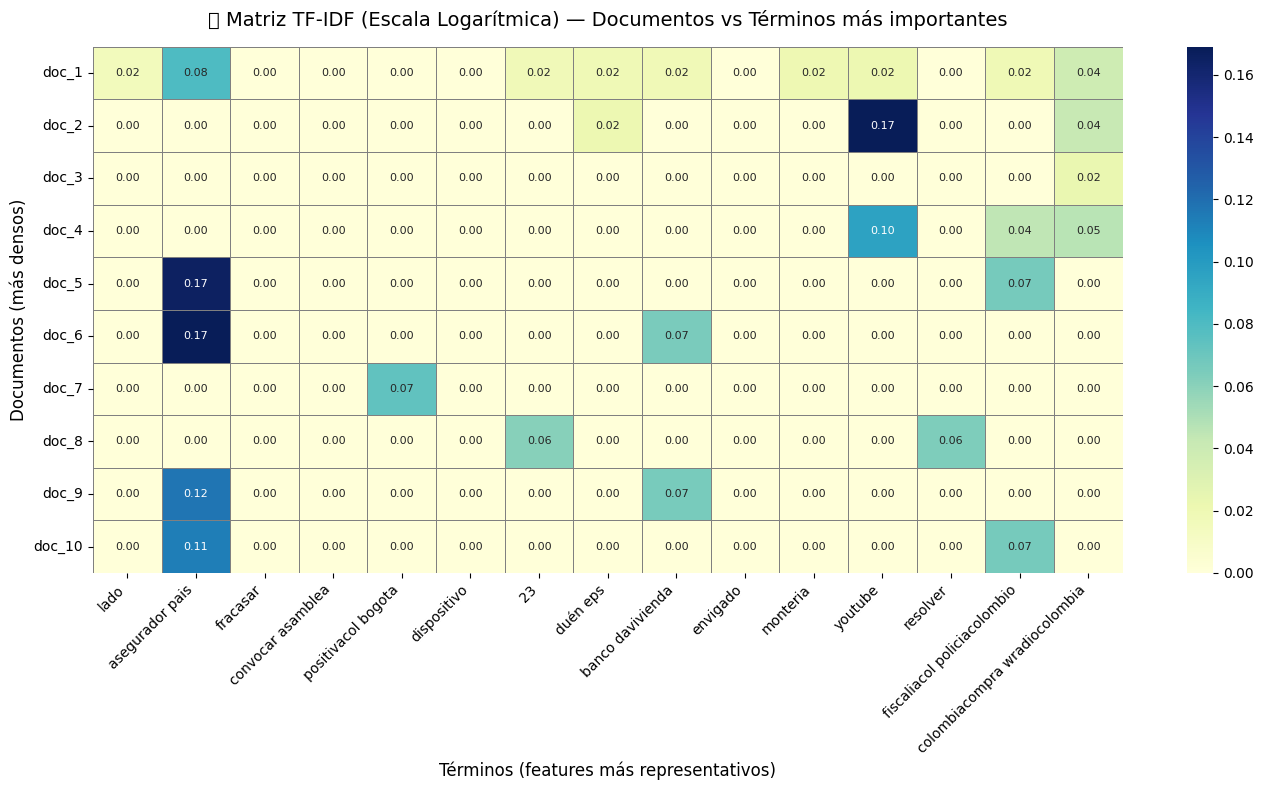

In [52]:
# ============================================
# Visualización robusta de la matriz TF-IDF
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que X y tfidf estén consistentes
n_docs, n_terms = X.shape
vocab_terms = np.array(tfidf.get_feature_names_out())
vocab_size = len(vocab_terms)

if vocab_size != n_terms:
    print(f"⚠️ Diferencia detectada: vocab={vocab_size}, matriz={n_terms}")
    n_terms = min(vocab_size, n_terms)
    vocab_terms = vocab_terms[:n_terms]
    print(f"✅ Ajustando vocabulario visible a {n_terms} términos.")

# 1️⃣ Promedio TF-IDF por término (importancia)
feature_means = np.asarray(X.mean(axis=0)).ravel()[:n_terms]
top_n_terms = min(15, n_terms)
top_terms_idx = np.argsort(feature_means)[::-1][:top_n_terms]
top_terms = vocab_terms[top_terms_idx]

# 2️⃣ Documentos más densos
doc_density = np.asarray((X > 0).sum(axis=1)).ravel()
top_n_docs = min(10, n_docs)
top_docs_idx = np.argsort(doc_density)[::-1][:top_n_docs]

# 3️⃣ Submatriz documentos x términos
X_sub = X[top_docs_idx, :][:, top_terms_idx].toarray()

# 4️⃣ DataFrame para visualización
df_vis = pd.DataFrame(X_sub, columns=top_terms)
df_vis.index = [f"doc_{i}" for i in range(1, len(top_docs_idx)+1)]

print(f"🔹 Muestra visual: {df_vis.shape[0]} docs × {df_vis.shape[1]} términos")
display(df_vis.round(3))
# ============================================
# 🔧 Versión calibrada de la matriz TF-IDF
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.figure(figsize=(14, 8))

# Evitar ruido con valores muy pequeños
X_sub_log = np.log1p(df_vis)  # log(1+x) para aumentar contraste en bajos TF-IDF

sns.heatmap(
    X_sub_log,
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    annot=True, fmt=".2f",
    annot_kws={"size": 8},
    vmin=0, vmax=X_sub_log.max().max()
)

plt.title("🧭 Matriz TF-IDF (Escala Logarítmica) — Documentos vs Términos más importantes", fontsize=14, pad=15)
plt.xlabel("Términos (features más representativos)", fontsize=12)
plt.ylabel("Documentos (más densos)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


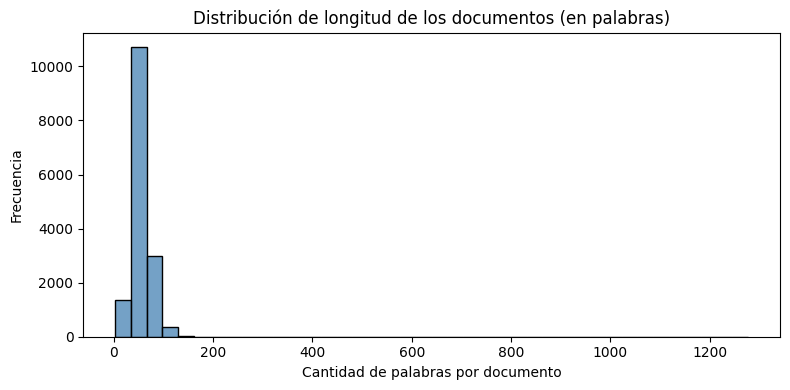

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...


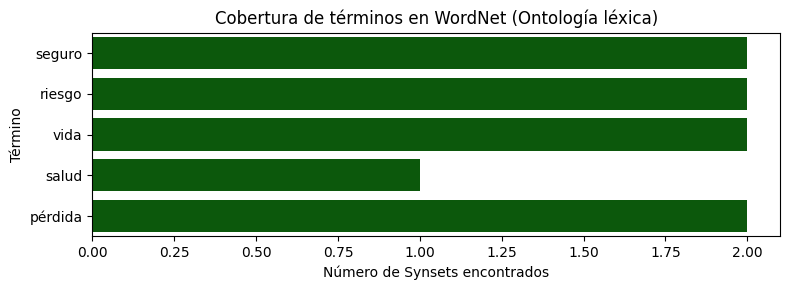

Diversidad léxica: 0.064


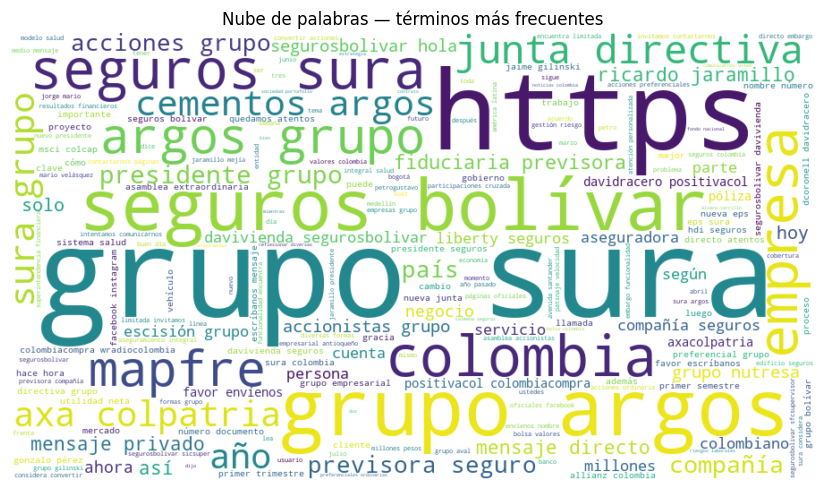

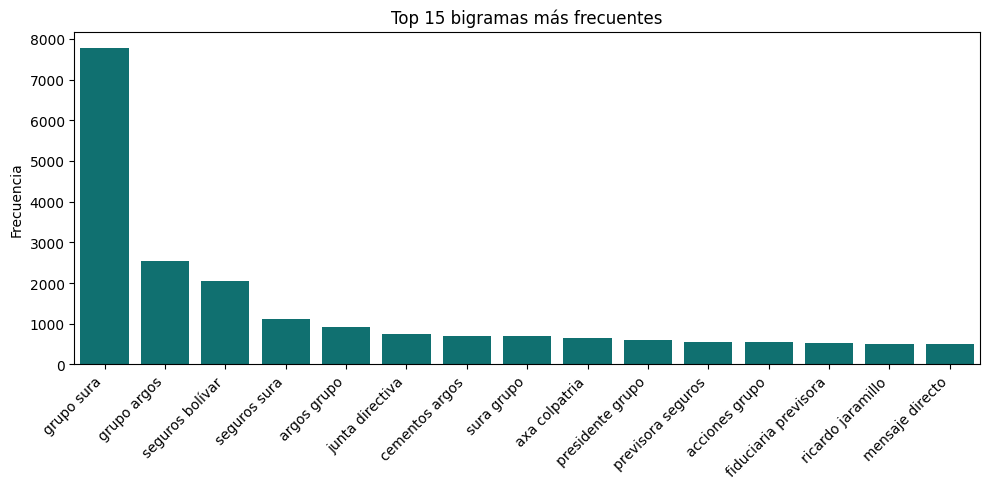

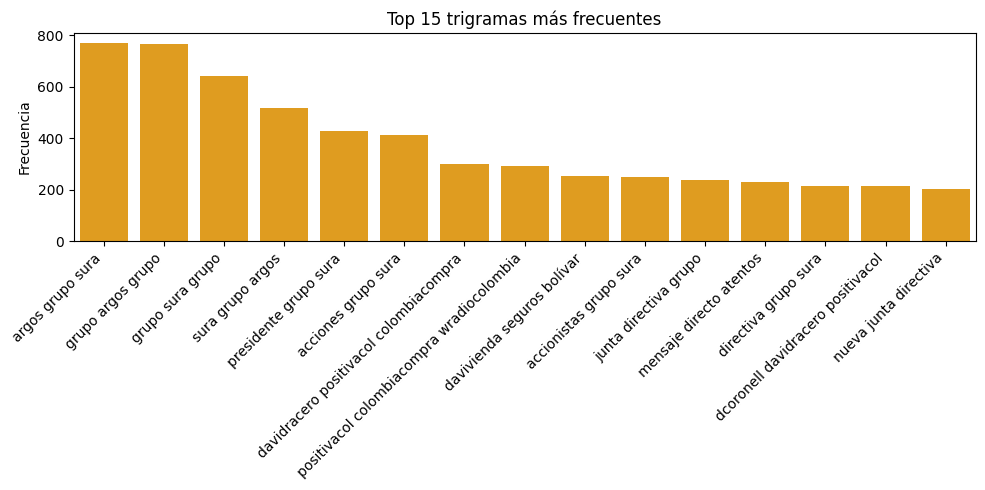

In [53]:
# ============================================
# ANÁLISIS EXPLORATORIO AVANZADO DEL CORPUS
# ============================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk import bigrams, trigrams
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# === 0. Cargar corpus ===
df = pd.read_csv("corpus_con_temas_final.csv")
textos = df["text_clean_base"].fillna("").astype(str).tolist()
sw = set(stopwords.words("spanish"))

# ============================================================
# 1️⃣ ANÁLISIS EXPLORATORIO AVANZADO — DISTRIBUCIÓN DE LONGITUD Y FRECUENCIAS
# ============================================================
df["longitud_palabras"] = df["text_clean_base"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
sns.histplot(df["longitud_palabras"], bins=40, color="steelblue")
plt.title("Distribución de longitud de los documentos (en palabras)")
plt.xlabel("Cantidad de palabras por documento")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# ============================================================
# 2️⃣ INTEGRACIÓN DE ONTOLOGÍAS O TESAUROS (EJEMPLO CON WORDNET)
# ============================================================
from nltk.corpus import wordnet as wn
nltk.download('omw-1.4')
nltk.download('wordnet')

terminos_demo = ["seguro", "riesgo", "vida", "salud", "pérdida"]
relaciones = []
for t in terminos_demo:
    syns = wn.synsets(t, lang='spa')
    for s in syns[:2]:
        relaciones.append((t, s.name().split(".")[0], s.definition()))

rel_df = pd.DataFrame(relaciones, columns=["Término","Synset","Definición"])
plt.figure(figsize=(8,3))
sns.countplot(y="Término", data=rel_df, color="darkgreen")
plt.title("Cobertura de términos en WordNet (Ontología léxica)")
plt.xlabel("Número de Synsets encontrados")
plt.tight_layout()
plt.show()

# ============================================================
# 3️⃣ MÉTRICAS DE DIVERSIDAD LÉXICA, COOCURRENCIAS Y N-GRAMAS
# ============================================================
from nltk.tokenize import word_tokenize

# Tokenización y limpieza
tokens = []
for txt in textos:
    words = [w.lower() for w in word_tokenize(re.sub(r"[^A-Za-zÁÉÍÓÚÜÑáéíóúüñ]", " ", txt)) if w.lower() not in sw and len(w) > 2]
    tokens.extend(words)

# Diversidad léxica
diversidad = len(set(tokens)) / len(tokens)
print(f"Diversidad léxica: {diversidad:.3f}")

# --- WordCloud de términos más frecuentes ---
wc = WordCloud(width=900, height=500, background_color="white", colormap="viridis").generate(" ".join(tokens))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras — términos más frecuentes")
plt.tight_layout()
plt.show()

# --- Bigramas y trigramas ---
bi = Counter(bigrams(tokens))
tri = Counter(trigrams(tokens))
top_bi = bi.most_common(15)
top_tri = tri.most_common(15)

# --- Gráfico de bigramas ---
plt.figure(figsize=(10,5))
sns.barplot(x=[f"{a} {b}" for (a,b),_ in top_bi], y=[v for _,v in top_bi], color="teal")
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 bigramas más frecuentes")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# --- Gráfico de trigramas ---
plt.figure(figsize=(10,5))
sns.barplot(x=[f"{a} {b} {c}" for (a,b,c),_ in top_tri], y=[v for _,v in top_tri], color="orange")
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 trigramas más frecuentes")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


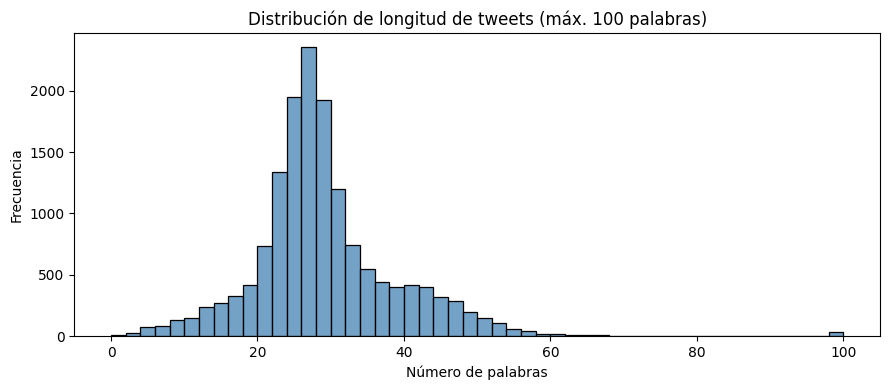

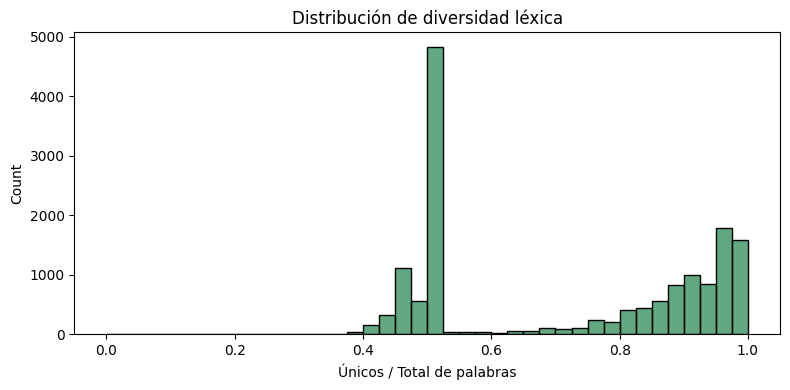

Diversidad léxica global: 0.072


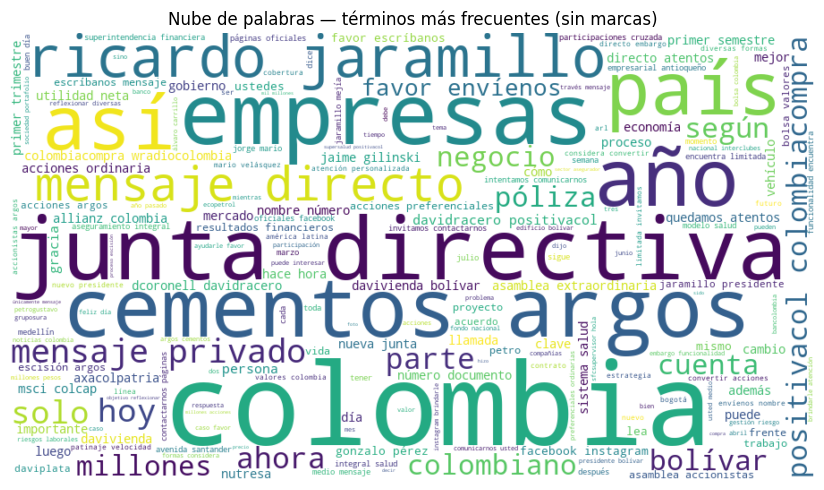

C:\Users\santi\AppData\Local\Temp\ipykernel_13576\2351780674.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="frecuencia", y="término", data=tb, ax=axes[i], palette="crest")
C:\Users\santi\AppData\Local\Temp\ipykernel_13576\2351780674.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="frecuencia", y="término", data=tb, ax=axes[i], palette="crest")
C:\Users\santi\AppData\Local\Temp\ipykernel_13576\2351780674.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="frecuencia", y="término", data=tb, ax=axes[i], palette="crest")
C

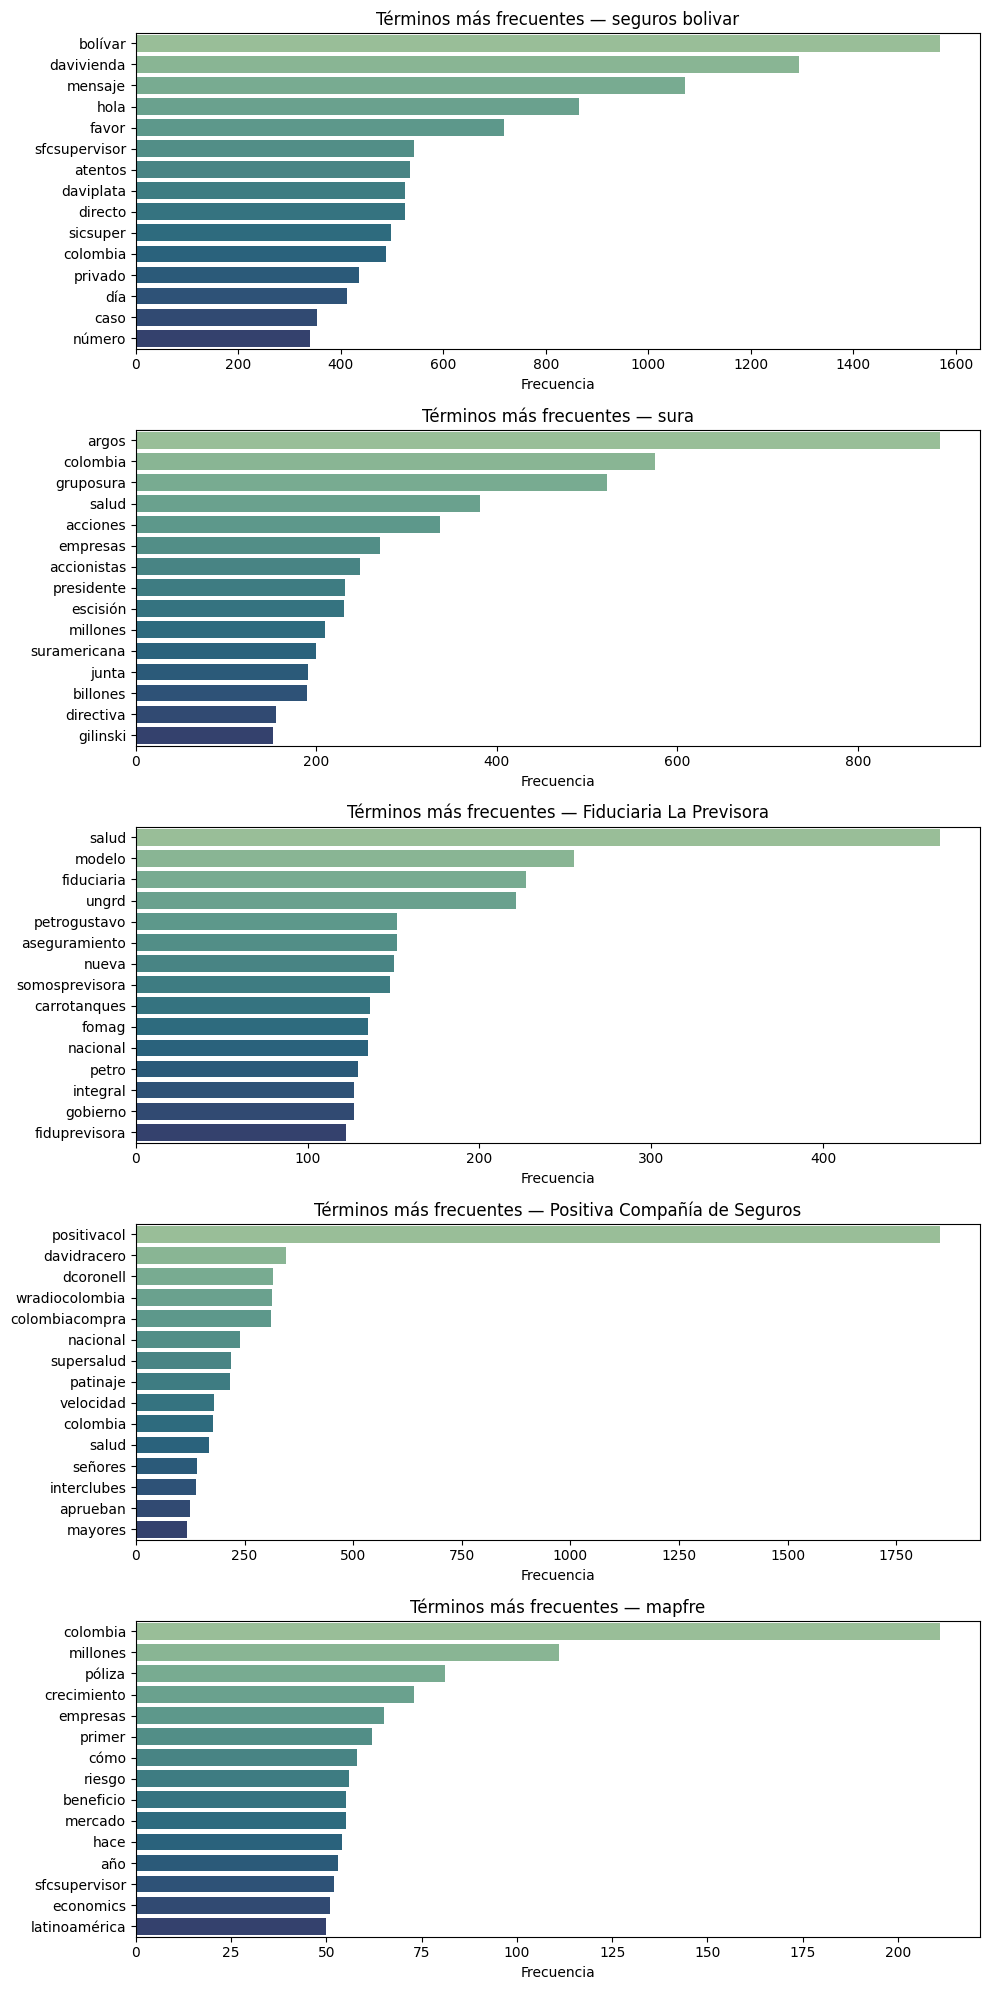

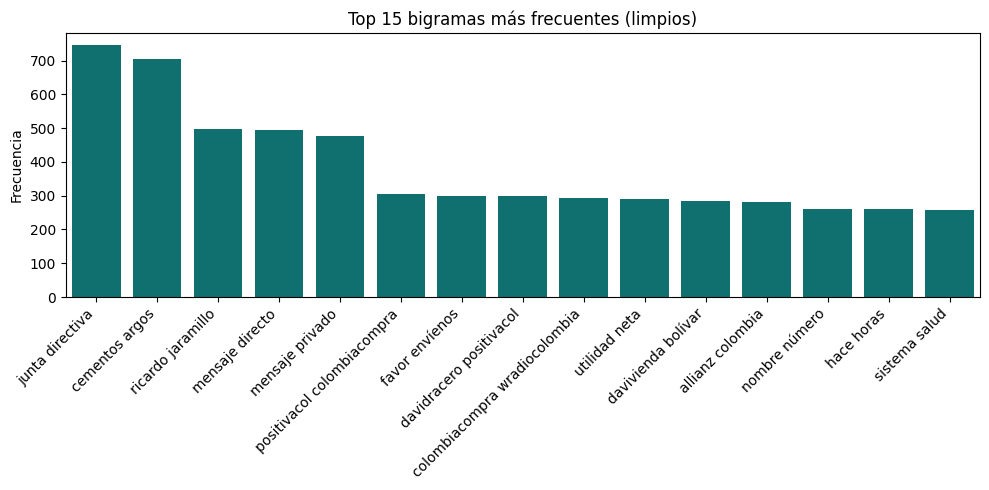

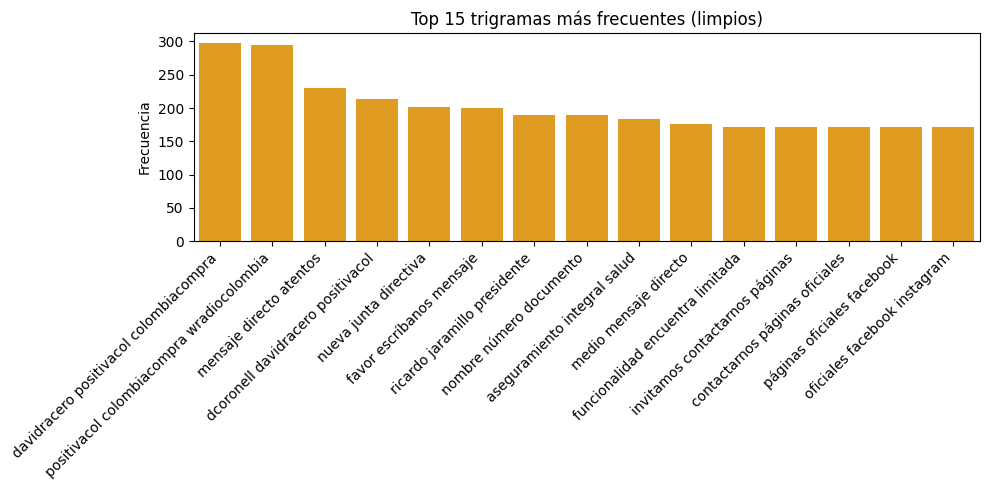

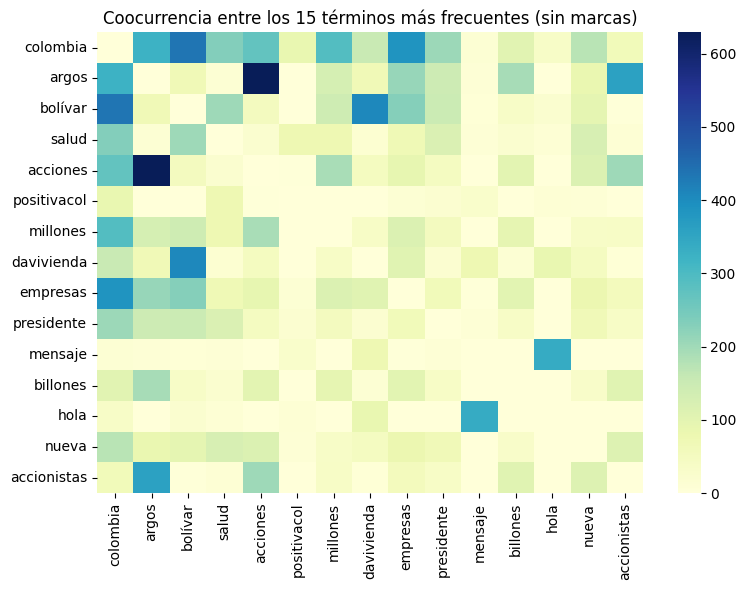

In [56]:
# ============================================
# ANÁLISIS EXPLORATORIO AVANZADO (DEPURADO)
# ============================================
import pandas as pd, re, nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk import word_tokenize, bigrams, trigrams
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

# === 0. Cargar corpus y definiciones previas ===
df = pd.read_csv("corpus_con_temas_final.csv")
text_col = "text_clean_base"
brand_col = "brand_primary"
df[text_col] = df[text_col].fillna("").astype(str)

# === 1. Stopwords y exclusiones del dominio ===
sw = set(stopwords.words("spanish")) | {"https","t","co"}
DOMAIN_STOPWORDS = {
    "seguro","seguros","eps","soat","compañía","compania","aseguradora",
    "aseguradoras","grupo","holding","empresa","entidad","clientes",
    "usuarios","servicio","producto"
}
BRANDS = {
    "bolivar","segurosbolivar","sura","mapfre","axa","colpatria","liberty",
    "previsora","positiva","equidad","mundial","solidaria","estado","zurich"
}
CUSTOM_STOPWORDS = sw | DOMAIN_STOPWORDS | BRANDS

def clean_tokens(text):
    tokens = [w.lower() for w in word_tokenize(re.sub(r"[^A-Za-zÁÉÍÓÚÜÑáéíóúüñ]", " ", text))]
    return [w for w in tokens if w not in CUSTOM_STOPWORDS and len(w) > 2]

df["tokens"] = df[text_col].apply(clean_tokens)
all_tokens = [t for sub in df["tokens"] for t in sub]

# ============================================================
# 1️⃣ DIVERSIDAD Y LONGITUD
# ============================================================
df["longitud_palabras"] = df["tokens"].apply(len)
df["diversidad"] = df["tokens"].apply(lambda x: len(set(x))/len(x) if len(x)>0 else 0)

# ============================================
# Distribución de longitud de documentos (máx. 100 palabras)
# ============================================

# Limitar los tokens a 100 palabras por documento
df["tokens_limited"] = df["tokens"].apply(lambda x: x[:100])

# Calcular longitud y diversidad sobre la versión truncada
df["longitud_palabras"] = df["tokens_limited"].apply(len)
df["diversidad"] = df["tokens_limited"].apply(lambda x: len(set(x))/len(x) if len(x) > 0 else 0)

# Graficar distribución de longitud
plt.figure(figsize=(9,4))
sns.histplot(df["longitud_palabras"], bins=50, color="steelblue")
plt.title("Distribución de longitud de tweets (máx. 100 palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,4))
sns.histplot(df["diversidad"], bins=40, color="seagreen")
plt.title("Distribución de diversidad léxica")
plt.xlabel("Únicos / Total de palabras")
plt.tight_layout()
plt.show()

print(f"Diversidad léxica global: {len(set(all_tokens))/len(all_tokens):.3f}")

# ============================================================
# 2️⃣ NUBE DE PALABRAS GLOBAL (sin stopwords, sin marcas)
# ============================================================
wc = WordCloud(width=900, height=500, background_color="white", colormap="viridis").generate(" ".join(all_tokens))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras — términos más frecuentes (sin marcas)")
plt.tight_layout()
plt.show()

# ============================================================
# 3️⃣ TÉRMINOS MÁS FRECUENTES POR ENTIDAD (limpios)
# ============================================================
def top_terms_by_brand(df, brand, n=15):
    subset = df[df[brand_col]==brand]
    tokens = [t for sub in subset["tokens"] for t in sub]
    filtered = [t for t in tokens if t not in CUSTOM_STOPWORDS]
    common = Counter(filtered).most_common(n)
    return pd.DataFrame(common, columns=["término","frecuencia"])

brands_top = df[brand_col].value_counts().head(5).index.tolist()
fig, axes = plt.subplots(len(brands_top), 1, figsize=(10, 4*len(brands_top)))
for i, brand in enumerate(brands_top):
    tb = top_terms_by_brand(df, brand)
    sns.barplot(x="frecuencia", y="término", data=tb, ax=axes[i], palette="crest")
    axes[i].set_title(f"Términos más frecuentes — {brand}")
    axes[i].set_xlabel("Frecuencia")
    axes[i].set_ylabel("")
plt.tight_layout()
plt.show()

# ============================================================
# 4️⃣ BIGRAMAS Y TRIGRAMAS (SIN STOPWORDS NI MARCAS)
# ============================================================
bi = Counter(bigrams(all_tokens))
tri = Counter(trigrams(all_tokens))

# Filtramos bigramas y trigramas que contengan marcas o stopwords
def is_clean_ngram(ngram):
    return all(t not in CUSTOM_STOPWORDS for t in ngram)

bi_clean = Counter({bg:v for bg,v in bi.items() if is_clean_ngram(bg)})
tri_clean = Counter({tg:v for tg,v in tri.items() if is_clean_ngram(tg)})

top_bi = bi_clean.most_common(15)
top_tri = tri_clean.most_common(15)

plt.figure(figsize=(10,5))
sns.barplot(x=[f"{a} {b}" for (a,b),_ in top_bi], y=[v for _,v in top_bi], color="teal")
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 bigramas más frecuentes (limpios)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=[f"{a} {b} {c}" for (a,b,c),_ in top_tri], y=[v for _,v in top_tri], color="orange")
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 trigramas más frecuentes (limpios)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# ============================================================
# 5️⃣ MATRIZ DE COOCURRENCIA (LÉXICO LIMPIO)
# ============================================================
import numpy as np
top_terms = [w for w,_ in Counter(all_tokens).most_common(15)]
matrix = pd.DataFrame(0, index=top_terms, columns=top_terms)
for toks in df["tokens"]:
    toks_set = set(toks)
    for a in top_terms:
        for b in top_terms:
            if a!=b and a in toks_set and b in toks_set:
                matrix.loc[a,b]+=1

plt.figure(figsize=(8,6))
sns.heatmap(matrix, cmap="YlGnBu", annot=False)
plt.title("Coocurrencia entre los 15 términos más frecuentes (sin marcas)")
plt.tight_layout()
plt.show()

